In [1]:
from typing import Tuple, Dict, List, Iterator
import os
import numpy as np
from PIL import Image
from numba import njit, prange, uint64, uint8, int8, int64
import matplotlib.pyplot as plt

In [2]:
img = Image.open("C:/Users/John Ingle/Videos/Tests/ferrari/39.png")
img_copy = img.copy()
img_array = np.array(img_copy)
print(img_array.shape, img_array.dtype)

(1080, 1920, 3) uint8


In [3]:
# dir(img_array)

In [4]:
def create_segments(img: np.array, shape: Tuple[int, int]):
    pass
    
# @jit(nopython=True)
def add_image_noise(img: np.array) -> np.array:
    noisy = img + np.random.poisson(1, img.shape)
    plt.imshow(noisy)
    

In [5]:
img_seg = img_array[0:512,0:512]
img_seg.shape

(512, 512, 3)

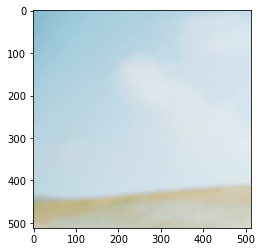

In [6]:
plt.imshow(img_seg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


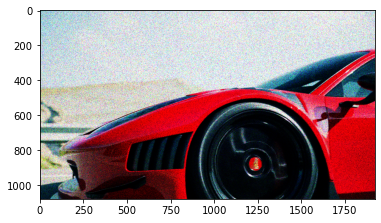

In [7]:
noisy = img_array / 255.0 * np.random.poisson(img_array / 100, img_array.shape) 
plt.imshow(noisy)

In [44]:
@njit(parallel=True, nopython=False)
def filter_by_brightness(img_array: np.array, min_value: int):
    img = img_array.astype(np.int64)
    height, width, depth = img_array.shape
    bool_map = np.zeros((height, width, 4))
    for i in prange(height):
        for j in prange(width):
            if img_array[i, j].sum() < min_value:
                bool_map[i, j] = [1, 1, 1, 1]
    return bool_map

@njit(parallel=True, nopython=True)
def brightness_map_1d(dmap: np.array):
    height, width, depth = dmap.shape
    flat = np.ones((height, width))
    for i in prange(height):
        for j in prange(depth):
            flat[i, j] = dmap[i, j][0]
    return flat

@njit(parallel=True, nopython=False)
def brightness_mask(img_array: np.array, min_value: int):
    height, width, depth = img_array.shape
    img_alpha = np.zeros((height, width, 4))
    for i in prange(height):
        for j in prange(width):
            sumv = img_array[i, j].sum()
            multiplier = ((255.0 * 3.0) - sumv) / 3.0
            if sumv > min_value:
                
                img_alpha[i, j] = np.array(
                    [
                        img_array[i, j][0], 
                        img_array[i, j][1], 
                        img_array[i, j][2], 
                        255
                    ]
                )
            else:
                img_alpha[i, j] = np.array(
                    [
                        img_array[i, j][0], 
                        img_array[i, j][1], 
                        img_array[i, j][2], 
                        0
                    ]
                )                     
    return img_alpha

@njit(parallel=True)
def noisy_img_composite(source: np.array, noisy_img: np.array, brightness: float):
    comp = np.zeros(source.shape).astype(np.float64)
    height, width, depth = source.shape
    for i in prange(height):
        for j in prange(width):
            if source[i, j].sum() > brightness:
                comp[i, j] = source[i, j]
            else:
                factor = (source[i, j].sum() - brightness) / source[i, j].sum()
                noise = np.array([
                    noisy_img[i, j][0] * factor,
                    noisy_img[i, j][1] * factor,
                    noisy_img[i, j][2] * factor
                ])
                comp[i, j] = (source[i, j] + noise) / 2.0
    return comp
                
                

C:\Users\John Ingle\Anaconda3\envs\tf\lib\site-packages\numba\core\decorators.py:232: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


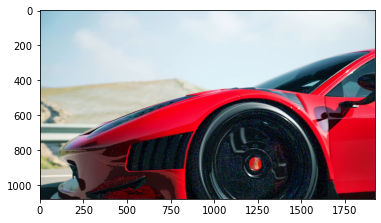

In [47]:
noisy_arr = img_array * np.random.poisson(img_array / 255.0, img_array.shape) * 1.2
comp = noisy_img_composite(img_array, noisy_arr, 160.0)
plt.imshow(comp.astype(np.uint8))

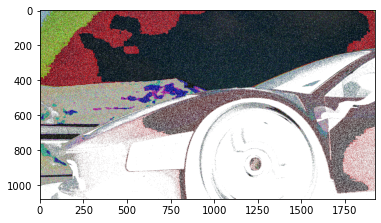

In [32]:

dark_img_noisy = brightness_mask(noisy_arr, 255)
dark_img_mask = Image.fromarray(dark_img_noisy.astype(np.uint8))
dark_img_mask.convert("RGBA")
plt.imshow(dark_img_mask)

In [11]:
print(dark_img_noisy.max(), dark_img_noisy.shape)

2214.0 (1080, 1920, 4)


In [12]:
dark_img_noisy[800, 1500]

array([  0.,   0.,   0., 255.])

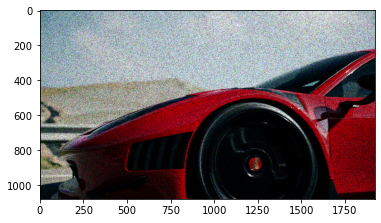

In [13]:
imga = img.copy()
imga.convert("L")
noisy_img = Image.fromarray(dark_img_noisy.astype(np.uint8))
noisy_img.convert("L")
imga.paste(noisy_img, box=(0, 0), mask=noisy_img)
plt.imshow(imga)

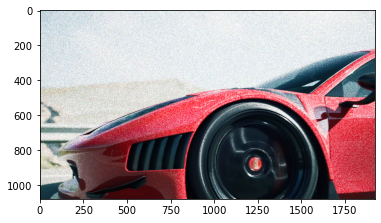

In [15]:
plt.imshow(Image.composite(img, dark_img_mask, dark_img_mask))

In [343]:
composite_noise = Image.fromarray(noisy.astype(np.uint8))

In [344]:
brightness_image = Image.fromarray(brightness_map.astype(np.uint8)).convert("L")

In [282]:
composite_noise.putalpha(brightness_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


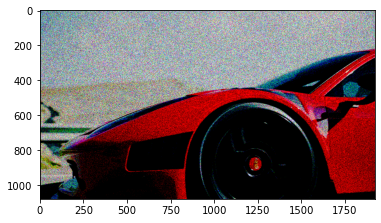

In [283]:
plt.imshow(np.array(composite_noise).astype(np.float64) / 0.001)